In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [3]:
def get_delays_and_profits(paths):
    output = None
    slave_ids = {}
    for path in paths:
        master_profit = None
        delays = {}
        slave_ids[path] = []
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    s_id = int(file.split('HerdSlaveAgent')[1].split('.')[0])
                    slave_ids[path].append(s_id)
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output, slave_ids

In [4]:
def get_herd_impact(paths, slaves):
    output = None
    for path in paths:
        df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
        df = df[df.EventType == 'ORDER_EXECUTED']
        df.reset_index(inplace=True)
        temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
        temp['EventTime'] = df.EventTime
        t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
        t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
        t['SIMULATION'] = path
        t['tot_vol'] = t1.tot_vol
        
        output = t if output is None else output.append(t)
    return output

Configuration 1

In [5]:
# end-time 12:00:00
# master-window 1e+9
# slave-min-delay 1e+1 
# slave-max-delay 1e+8
# 1 master
# 40 slaves
# limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_0/", "log/herd01_2_5_hour_1/", "log/herd01_2_5_hour_2/", "log/herd01_2_5_hour_3/", 
         "log/herd01_2_5_hour_4/", "log/herd01_2_5_hour_5/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,388394.0,199319.0,365427,log/herd01_2_5_hour_1/,0.545441
1,513294.0,34572.0,329913,log/herd01_2_5_hour_4/,0.104791
2,647346.0,87555.0,336637,log/herd01_2_5_hour_0/,0.260087
3,1046636.0,56100.0,329913,log/herd01_2_5_hour_4/,0.170045
4,2081557.0,104077.0,329913,log/herd01_2_5_hour_4/,0.315468
...,...,...,...,...,...
235,97775516.0,42040.0,336637,log/herd01_2_5_hour_0/,0.124882
236,97999578.0,111856.0,365427,log/herd01_2_5_hour_1/,0.306097
237,98847482.0,11855.0,336637,log/herd01_2_5_hour_0/,0.035216
238,98913519.0,25229.0,446145,log/herd01_2_5_hour_5/,0.056549


In [6]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  5.451039e+06  3.391201e+06  121466.566667  57698.744666  361788.566667   
1  2.011549e+07  5.326870e+06   81153.900000  72623.971065  372454.900000   
2  3.380075e+07  3.182857e+06   39698.833333  49934.195325  368777.700000   
3  4.504049e+07  4.113942e+06   40577.200000  34832.886657  374281.733333   
4  5.614587e+07  4.048804e+06   41396.433333  36005.700262  364933.633333   
5  6.858103e+07  4.457184e+06   34893.200000  30088.166931  373613.100000   
6  8.024152e+07  2.874059e+06   22624.900000  25490.133946  381073.000000   
7  9.225896e+07  4.061049e+06   24295.066667  24807.447112  366336.033333   

                  PERCENT            
            std      mean       std  
g                                    
0  33159.791368  0.335302  0.159015  
1  38049.902468  0.223475  0.212059  
2  39698.989359  0.105323  0.139609  
3  40390.554771  0.107873  0.097397  
4  36776.624928  0.112582  0.101762  
5  41828.035033  0.095524  0.089341  
6  40303.475642  0.059463  0.069428  
7  35891.557875  0.067591  0.071238

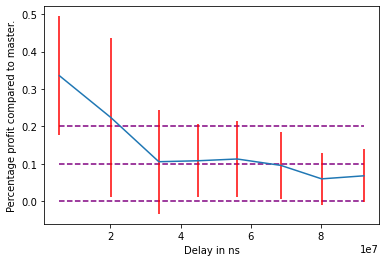

In [7]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [8]:
t = get_herd_impact(PATHS, slave_ids)

In [9]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100

In [10]:
#t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

EventTime    slave_vol                     tot_vol               \
                               mean          std           mean          std   
0  2020-06-03 09:30:00  3900.333333   688.082747  114884.500000  4726.771530   
1  2020-06-03 09:35:00  3530.833333   426.368581   39467.000000  1289.824484   
2  2020-06-03 09:40:00  3033.666667   652.823611   39208.500000   851.701297   
3  2020-06-03 09:45:00  4611.500000   874.859932   40586.666667  1831.665981   
4  2020-06-03 09:50:00  4891.833333   486.735007   41995.333333  1291.219527   
5  2020-06-03 09:55:00  4671.833333   781.141579   41423.333333  1796.707062   
6  2020-06-03 10:00:00  4730.500000   561.976423   41402.833333  1441.291423   
7  2020-06-03 10:05:00  4624.666667   548.327153   40988.333333   899.375932   
8  2020-06-03 10:10:00  4303.666667   333.659507   41200.333333  1416.265465   
9  2020-06-03 10:15:00  4298.500000   547.372542   40300.666667  1277.671111   
10 2020-06-03 10:20:00  4705.500000   498.381681   40619.000000  1184.602887   
11 2020-06-03 10:25:00  4190.000000   792.459967   39682.000000  2453.075213   
12 2020-06-03 10:30:00  4048.833333   836.079043   35628.833333   831.908509   
13 2020-06-03 10:35:00  5193.833333   854.558697   35712.333333   864.445179   
14 2020-06-03 10:40:00  5441.333333   516.896379   36534.000000  1065.140742   
15 2020-06-03 10:45:00  5223.333333  1043.549264   36629.333333  1183.686389   
16 2020-06-03 10:50:00  5340.666667   679.646281   36365.666667  1467.170565   
17 2020-06-03 10:55:00  5143.333333   714.100460   36525.333333  1493.205902   
18 2020-06-03 11:00:00  5731.500000   845.362822   36404.000000   980.943627   
19 2020-06-03 11:05:00  4863.833333   870.340489   35674.666667  1732.603436   
20 2020-06-03 11:10:00  5155.666667   750.915885   34978.666667  1408.629073   
21 2020-06-03 11:15:00  5686.666667   517.622127   36233.333333  1828.923253   
22 2020-06-03 11:20:00  5271.333333   972.875874   36239.166667  1611.738864   
23 2020-06-03 11:25:00  4917.833333   809.298565   35113.333333  1587.639086   
24 2020-06-03 11:30:00  5290.833333   389.968418   35265.166667   824.107618   
25 2020-06-03 11:35:00  4858.666667   453.994126   34886.666667  1381.906750   
26 2020-06-03 11:40:00  5547.166667  1071.873764   35600.333333  1020.626605   
27 2020-06-03 11:45:00  5157.500000  1438.304662   35363.000000  1802.528446   
28 2020-06-03 11:50:00  4344.166667   829.435571   35070.666667  1852.773668   
29 2020-06-03 11:55:00  5308.500000  1143.197927   35676.166667  1251.582904   

      PERCENT            
         mean       std  
0    3.392693  0.553925  
1    8.933642  0.931325  
2    7.746113  1.696320  
3   11.327919  1.961187  
4   11.638393  0.995645  
5   11.239155  1.415773  
6   11.409739  1.117771  
7   11.277718  1.259505  
8   10.443394  0.677921  
9   10.658428  1.242297  
10  11.598951  1.336004  
11  10.532638  1.694865  
12  11.352253  2.301277  
13  14.531566  2.234185  
14  14.874618  1.053183  
15  14.211764  2.469864  
16  14.655091  1.449889  
17  14.082110  1.852417  
18  15.737568  2.188305  
19  13.595228  2.092579  
20  14.696338  1.690930  
21  15.720726  1.536357  
22  14.480755  2.118155  
23  13.983007  2.037663  
24  14.999024  0.977213  
25  13.932962  1.288099  
26  15.550410  2.752550  
27  14.533704  3.674924  
28  12.323516  1.843998  
29  14.840742  2.890259

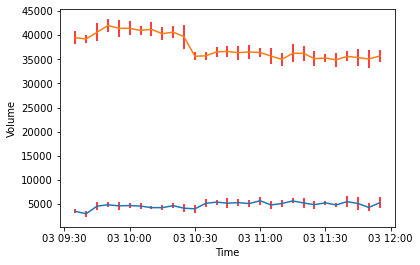

In [11]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

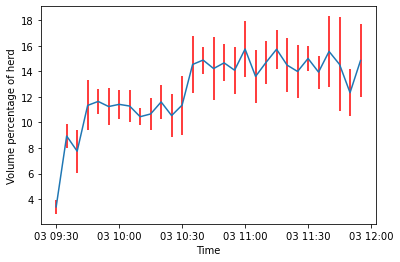

In [12]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Configuration 2

In [15]:
# Changed slave strategy to this.


# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(self.symbol) * (-1) if self.getHoldings(self.symbol) < 0 else order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])


PATHS = ["log/herd01_2_5_hour_0_s/", "log/herd01_2_5_hour_1_s/", "log/herd01_2_5_hour_2_s/", "log/herd01_2_5_hour_3_s/", 
         "log/herd01_2_5_hour_4_s/", "log/herd01_2_5_hour_5_s/", "log/herd01_2_5_hour_6_s/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,388394.0,108934.0,366561,log/herd01_2_5_hour_1_s/,0.297178
1,456249.0,95516.0,356272,log/herd01_2_5_hour_6_s/,0.268099
2,513294.0,119572.0,329622,log/herd01_2_5_hour_4_s/,0.362755
3,1046636.0,111905.0,329622,log/herd01_2_5_hour_4_s/,0.339495
4,2035991.0,90877.0,356272,log/herd01_2_5_hour_6_s/,0.255078
...,...,...,...,...,...
275,98383093.0,40068.0,322969,log/herd01_2_5_hour_0_s/,0.124061
276,98913519.0,32077.0,413491,log/herd01_2_5_hour_5_s/,0.077576
277,99055962.0,49983.0,322969,log/herd01_2_5_hour_0_s/,0.154761
278,99723573.0,-30457.0,414653,log/herd01_2_5_hour_2_s/,-0.073452


In [16]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std          mean           std           mean   
g                                                                          
0  4.056318e+06  2.252467e+06  98140.333333  26769.401159  363407.300000   
1  1.435847e+07  3.694651e+06  74645.866667  37932.847820  364988.966667   
2  2.756487e+07  3.787843e+06  70837.400000  47105.471163  376423.966667   
3  3.764420e+07  2.565958e+06  59831.366667  61388.219196  380583.166667   
4  4.778333e+07  3.249260e+06  65521.500000  44506.499145  374627.233333   
5  6.014319e+07  3.758946e+06  39903.166667  23105.165889  366072.300000   
6  7.077817e+07  3.148552e+06  28915.466667  55494.915863  362583.766667   
7  8.000423e+07  2.660205e+06  16059.300000  45655.992190  381955.100000   
8  9.059479e+07  3.327366e+06  35808.933333  36636.520185  375693.600000   
9  9.838022e+07  9.795903e+05  15495.800000  29337.921512  361377.800000   

                  PERCENT            
            std      mean       std  
g                                    
0  33672.587973  0.272846  0.079810  
1  35166.789540  0.207689  0.108920  
2  35509.387406  0.190438  0.132702  
3  31745.731218  0.158435  0.170857  
4  36004.351688  0.175431  0.118806  
5  37550.526973  0.111713  0.067416  
6  33749.389016  0.082167  0.163390  
7  34434.791285  0.042051  0.128574  
8  34759.966053  0.101450  0.106939  
9  39961.407916  0.046482  0.083767

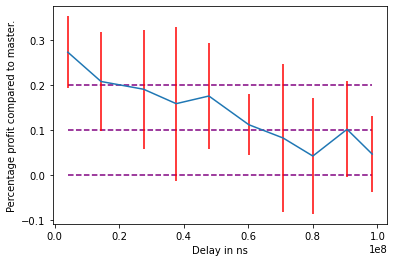

In [17]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config. 3

In [18]:
# Changed limit orders to market orders and moved the message from accepted to placed
# changed to master-window 5e+9


PATHS = ["log/herd01_2_5_hour_1_t/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,388394.0,147503.0,156995,log/herd01_2_5_hour_1_t/,0.939539
1,2680074.0,93384.0,156995,log/herd01_2_5_hour_1_t/,0.594821
2,3958259.0,107773.0,156995,log/herd01_2_5_hour_1_t/,0.686474
3,4495277.0,121327.0,156995,log/herd01_2_5_hour_1_t/,0.772808
4,5643742.0,79985.0,156995,log/herd01_2_5_hour_1_t/,0.509475
5,8317616.0,134997.0,156995,log/herd01_2_5_hour_1_t/,0.859881
6,10534022.0,62690.0,156995,log/herd01_2_5_hour_1_t/,0.399312
7,18072244.0,-11945.0,156995,log/herd01_2_5_hour_1_t/,-0.076085
8,18643108.0,44213.0,156995,log/herd01_2_5_hour_1_t/,0.281620
9,21308759.0,25422.0,156995,log/herd01_2_5_hour_1_t/,0.161929


In [19]:
df['g'] = df.index//3
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT               MASTER_PROFIT  \
            mean           std           mean           std          mean   
g                                                                           
0   2.342242e+06  1.808751e+06  116220.000000  28030.882915        156995   
1   6.152212e+06  1.961243e+06  112103.000000  28642.480130        156995   
2   1.574979e+07  4.525998e+06   31652.666667  38870.519502        156995   
3   2.537738e+07  5.241641e+06   -6096.000000  39902.349292        156995   
4   3.261226e+07  9.286816e+05  -61230.333333  26484.518012        156995   
5   3.588426e+07  2.700730e+06 -111832.333333  18412.223042        156995   
6   4.646665e+07  3.680217e+06 -141385.666667  16944.212148        156995   
7   5.173578e+07  1.589215e+06 -191636.333333  11023.598157        156995   
8   5.885209e+07  2.704560e+06 -214545.333333  40634.557723        156995   
9   6.444957e+07  2.425721e+06 -244748.000000  22673.246812        156995   
10  7.632901e+07  3.198529e+06 -297156.333333  14486.516156        156995   
11  8.235676e+07  3.718271e+06 -301762.000000  35278.214283        156995   
12  9.241064e+07  2.456763e+06 -325741.666667   8056.405919        156995   
13  9.799958e+07           NaN -347390.000000           NaN        156995   

          PERCENT            
    std      mean       std  
g                            
0   0.0  0.740278  0.178546  
1   0.0  0.714055  0.182442  
2   0.0  0.201616  0.247591  
3   0.0 -0.038829  0.254163  
4   0.0 -0.390015  0.168697  
5   0.0 -0.712331  0.117279  
6   0.0 -0.900574  0.107928  
7   0.0 -1.220652  0.070216  
8   0.0 -1.366574  0.258827  
9   0.0 -1.558954  0.144420  
10  0.0 -1.892776  0.092274  
11  0.0 -1.922112  0.224709  
12  0.0 -2.074854  0.051316  
13  NaN -2.212746       NaN

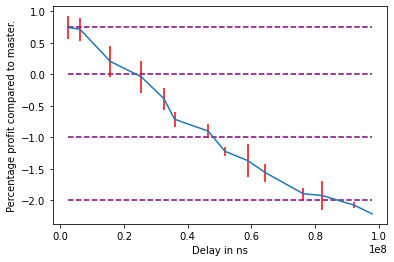

In [20]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.75, -1, -2], xmin=[xmin, xmin, xmin, xmin], xmax=[xmax, xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 4.

In [21]:
# end-time 12:00:00
# changed to master-window 5e+9
# slave-min-delay 1e+1 
# changed to slave-max-delay 1e+9
# 1 master
# changed to 60 slaves
# changed to 100 momentum agents
# back to limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(symbol) * (-1) if self.getHoldings(symbol) < 0 else quantity
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_1_z/", "log/herd01_2_5_hour_2_z/", "log/herd01_2_5_hour_3_z/", 
         "log/herd01_2_5_hour_4_z/", "log/herd01_2_5_hour_5_z/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,1563447,125691,127564,log/herd01_2_5_hour_3_z/,0.985317
1,2215065,113742,102557,log/herd01_2_5_hour_4_z/,1.109061
2,3872701,131254,130525,log/herd01_2_5_hour_1_z/,1.005585
3,15164879,122671,127564,log/herd01_2_5_hour_3_z/,0.961643
4,20736044,119007,130525,log/herd01_2_5_hour_1_z/,0.911756
...,...,...,...,...,...
295,985127515,57888,127564,log/herd01_2_5_hour_3_z/,0.453796
296,990030068,-8186,102557,log/herd01_2_5_hour_4_z/,-0.079819
297,993749745,56867,127471,log/herd01_2_5_hour_2_z/,0.446117
298,993903303,-89846,102557,log/herd01_2_5_hour_4_z/,-0.876059


In [22]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  5.597828e+07  3.704302e+07  115010.266667  11148.036750  125311.800000   
1  1.647523e+08  2.569083e+07  127159.233333  37558.610696  124379.533333   
2  2.618174e+08  3.377924e+07  115332.066667  41370.223814  125854.866667   
3  3.789010e+08  3.252221e+07   97093.300000  30434.532012  128541.166667   
4  4.595270e+08  2.348842e+07   84036.166667  36196.134336  125719.600000   
5  5.719438e+08  3.465195e+07  102010.233333  60207.329848  127608.900000   
6  6.759497e+08  2.928421e+07   69828.333333  66574.591633  122491.333333   
7  7.586702e+08  2.225638e+07   93778.166667  84650.715946  123258.566667   
8  8.337986e+08  2.598526e+07   81739.833333  84178.051818  122254.266667   
9  9.534555e+08  3.131740e+07   59708.566667  87748.111603  123743.966667   

                  PERCENT            
            std      mean       std  
g                                    
0  12057.258934  0.924058  0.110929  
1  12704.163221  1.052942  0.429605  
2  11104.348622  0.917512  0.318697  
3   7942.299203  0.749379  0.213340  
4  12253.114772  0.653731  0.273980  
5   9237.276563  0.821488  0.587841  
6  11339.031122  0.556294  0.566679  
7  13097.374816  0.773024  0.792856  
8  12371.536506  0.630506  0.715235  
9  13445.589790  0.466533  0.761972

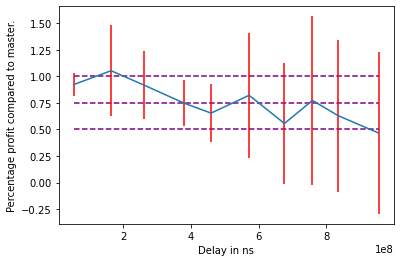

In [23]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.5, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 5

In [24]:
# I try to make it a bit more realistic with the herd representing a small volume of the total transactions.
# changed to master-window 3e+9 
# changed to slave-max-delay 1e+9
# changed order size from 5 to 2
# 1 master
# changed to 40 slaves
# changed to 300 momentum agents
# limit orders

# Master Strategy unchanged

# Slave Strategy unchanged


PATHS = ["log/herd01_2_5_hour_1_x/", "log/herd01_2_5_hour_2_x/", "log/herd01_2_5_hour_3_x/", 
         "log/herd01_2_5_hour_4_x/", "log/herd01_2_5_hour_5_x/", "log/herd01_2_5_hour_6_x/", 
         "log/herd01_2_5_hour_7_x/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,3193213.0,334575.0,332944,log/herd01_2_5_hour_3_x/,1.004899
1,4476082.0,257920.0,241406,log/herd01_2_5_hour_4_x/,1.068408
2,8511145.0,321844.0,332944,log/herd01_2_5_hour_3_x/,0.966661
3,11502236.0,308613.0,252997,log/herd01_2_5_hour_2_x/,1.219829
4,26423235.0,252718.0,158810,log/herd01_2_5_hour_7_x/,1.591323
...,...,...,...,...,...
275,981637853.0,246565.0,321639,log/herd01_2_5_hour_5_x/,0.766589
276,981842354.0,155991.0,332944,log/herd01_2_5_hour_3_x/,0.468520
277,984922342.0,249132.0,321639,log/herd01_2_5_hour_5_x/,0.774570
278,997209638.0,150706.0,332944,log/herd01_2_5_hour_3_x/,0.452647


In [25]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  4.883703e+07  2.666372e+07  299924.800000  75236.045903  253520.666667   
1  1.597252e+08  3.472797e+07  250042.166667  67557.714120  250506.266667   
2  2.632863e+08  2.178397e+07  217594.066667  55615.021250  251601.366667   
3  3.564919e+08  3.134269e+07  203754.800000  86890.504588  238114.166667   
4  4.677539e+08  2.735918e+07  185179.900000  69674.810201  243598.033333   
5  5.751848e+08  3.143697e+07  170507.466667  61246.746163  257141.800000   
6  6.749900e+08  2.902235e+07  186663.633333  70507.018768  246426.900000   
7  7.789188e+08  3.138182e+07  167903.866667  72616.344965  258930.900000   
8  9.010570e+08  3.833104e+07  165817.966667  82039.960329  234219.666667   
9  9.796286e+08  1.251785e+07  174697.200000  60441.209893  286168.700000   

                  PERCENT            
            std      mean       std  
g                                    
0  65024.327432  1.295432  0.640422  
1  57513.507574  1.071453  0.522320  
2  58022.729346  0.919627  0.388537  
3  62569.762128  0.921612  0.582146  
4  45733.726439  0.815356  0.482457  
5  55398.622381  0.713679  0.393841  
6  67568.585285  0.835514  0.490567  
7  64749.254123  0.667409  0.349596  
8  59339.588294  0.779606  0.527319  
9  59120.435837  0.645735  0.338049

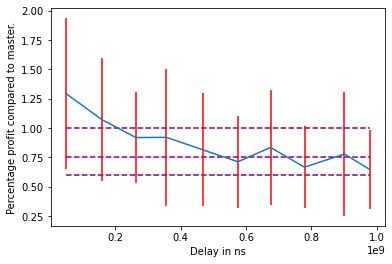

In [26]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [27]:
t = get_herd_impact(PATHS, slave_ids)

In [28]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

EventTime     slave_vol                      tot_vol  \
                                mean           std           mean   
0  2020-06-03 09:30:00   6495.857143    545.207737  112920.857143   
1  2020-06-03 09:35:00   7880.142857    838.081625   40859.714286   
2  2020-06-03 09:40:00   7849.142857   1510.789355   39716.714286   
3  2020-06-03 09:45:00   6830.571429   1776.634727   48676.142857   
4  2020-06-03 09:50:00   5473.000000   2318.507207   53221.000000   
5  2020-06-03 09:55:00   5769.142857   3231.391415   51267.714286   
6  2020-06-03 10:00:00   5331.285714   3480.441864   44029.285714   
7  2020-06-03 10:05:00   6819.142857   5828.288497   45384.000000   
8  2020-06-03 10:10:00   4400.000000   2079.595794   43346.142857   
9  2020-06-03 10:15:00   5336.142857   2902.835994   43884.285714   
10 2020-06-03 10:20:00   9711.142857   5879.304648   46534.857143   
11 2020-06-03 10:25:00   9604.285714  10317.235979   45538.000000   
12 2020-06-03 10:30:00   7125.285714   4272.359641   44656.428571   
13 2020-06-03 10:35:00   7947.285714   5172.994320   45142.428571   
14 2020-06-03 10:40:00   4716.428571   1502.231657   43262.428571   
15 2020-06-03 10:45:00   7735.714286   3974.440116   45681.428571   
16 2020-06-03 10:50:00   7494.285714   5888.635827   44710.571429   
17 2020-06-03 10:55:00   7260.857143   5606.705641   45199.571429   
18 2020-06-03 11:00:00   6829.857143   4840.084828   44180.857143   
19 2020-06-03 11:05:00   7497.428571   3827.658373   45000.285714   
20 2020-06-03 11:10:00   8629.571429   5579.238444   45239.857143   
21 2020-06-03 11:15:00   5546.714286   2863.713482   44170.571429   
22 2020-06-03 11:20:00   9428.285714   8473.230586   46066.571429   
23 2020-06-03 11:25:00   7369.714286   4661.135366   44493.142857   
24 2020-06-03 11:30:00  11066.142857   6090.068758   46750.428571   
25 2020-06-03 11:35:00   7767.857143   6101.383653   44104.571429   
26 2020-06-03 11:40:00   9642.857143   6201.143105   46016.714286   
27 2020-06-03 11:45:00   7814.000000   5144.564510   45145.000000   
28 2020-06-03 11:50:00   8659.428571   5244.306972   45804.428571   
29 2020-06-03 11:55:00   8067.857143   5303.334971   45241.714286   

                   PERCENT             
            std       mean        std  
0   7117.091668   5.767633   0.568836  
1   1355.533808  19.284220   1.913413  
2   1879.812288  19.659354   3.046324  
3   1243.722159  14.030877   3.588343  
4   1603.432568  10.234509   4.131906  
5   3195.240873  11.048129   5.421550  
6   1818.215583  11.876608   7.215294  
7   4659.399997  14.128838  10.402206  
8   2454.578404   9.972946   4.030248  
9   2336.328367  11.936800   5.922041  
10  4005.048915  20.087238  11.132579  
11  5358.420321  19.302764  18.121419  
12  2977.724739  15.532054   8.367148  
13  4245.509387  16.848107   9.621161  
14  1121.167228  10.842878   3.185183  
15  2201.464199  16.653113   7.795421  
16  3785.193604  16.045309  11.302175  
17  3657.720140  15.482968  10.199942  
18  2683.730329  15.005053   9.514828  
19  2934.514822  16.320237   7.453066  
20  2619.310814  18.619589  11.013297  
21  1947.229729  12.411543   5.799446  
22  4636.452554  19.268754  15.281368  
23  2843.915870  16.120104   8.906866  
24  3526.206028  23.024902  11.558634  
25  3428.356694  16.931543  11.446960  
26  3015.328435  20.358523  11.704486  
27  2691.189762  16.862265  10.088181  
28  3920.449713  18.359700   9.301928  
29  2394.025251  17.442852  10.336745

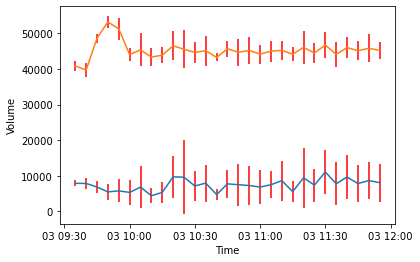

In [29]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

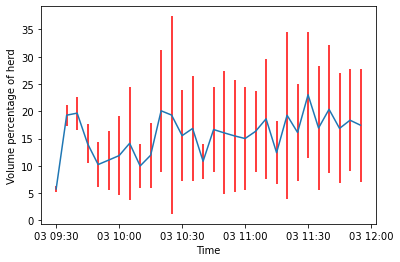

In [30]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 6

In [5]:
# Herd02 config

# I try to make it a bit more realistic with the herd representing a small volume of the total transactions.
# changed to master-window 3e+9 
# changed to slave-max-delay 1e+9
# changed order size from 5 to 2
# 1 master
# changed to 40 slaves
# changed to 300 momentum agents
# limit orders

# Master Strategy unchanged

# Slave Strategy unchanged


PATHS = ["log/herd02_2_5_hour_1/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,3872701,28649,31710,log/herd02_2_5_hour_1/,0.903469
1,20736044,29602,31710,log/herd02_2_5_hour_1/,0.933523
2,46211024,31095,31710,log/herd02_2_5_hour_1/,0.980605
3,52488231,31660,31710,log/herd02_2_5_hour_1/,0.998423
4,118597386,29562,31710,log/herd02_2_5_hour_1/,0.932261
5,145379030,29794,31710,log/herd02_2_5_hour_1/,0.939577
6,151296783,38093,31710,log/herd02_2_5_hour_1/,1.201293
7,211211304,36578,31710,log/herd02_2_5_hour_1/,1.153516
8,251848870,30893,31710,log/herd02_2_5_hour_1/,0.974235
9,258971955,43077,31710,log/herd02_2_5_hour_1/,1.358467


In [6]:
df['g'] = df.index//4
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY               SLAVE_PROFIT               MASTER_PROFIT       \
           mean           std         mean           std          mean  std   
g                                                                             
0  3.082700e+07  2.261444e+07     30251.50   1376.616746         31710  0.0   
1  1.566211e+08  3.907525e+07     33506.75   4465.117794         31710  0.0   
2  2.614612e+08  8.541839e+06     42740.25   8321.927716         31710  0.0   
3  3.084351e+08  3.130664e+07     47526.50    946.595831         31710  0.0   
4  3.994450e+08  2.683153e+07     50127.00   4282.742268         31710  0.0   
5  4.434187e+08  7.063454e+06     43400.25   7093.412408         31710  0.0   
6  6.213628e+08  4.739457e+07     31066.25  16910.554976         31710  0.0   
7  7.201370e+08  2.587928e+07     28447.25  12994.278263         31710  0.0   
8  7.850419e+08  2.520737e+07     27879.75  15219.603047         31710  0.0   
9  8.666375e+08  3.455177e+07     40234.50   7365.334593         31710  0.0   

    PERCENT            
       mean       std  
g                      
0  0.954005  0.043413  
1  1.056662  0.140811  
2  1.347848  0.262439  
3  1.498786  0.029852  
4  1.580795  0.135060  
5  1.368661  0.223696  
6  0.979699  0.533288  
7  0.897107  0.409785  
8  0.879210  0.479962  
9  1.268827  0.232272

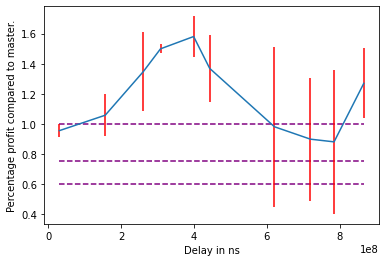

In [7]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [8]:
t = get_herd_impact(PATHS, slave_ids)
t

,slave_vol,SIMULATION,tot_vol
EventTime,,,
2020-06-03 09:30:00,6173,log/herd02_2_5_hour_1/,135506
2020-06-03 09:35:00,7313,log/herd02_2_5_hour_1/,40944
2020-06-03 09:40:00,8783,log/herd02_2_5_hour_1/,42328
2020-06-03 09:45:00,11990,log/herd02_2_5_hour_1/,48349
2020-06-03 09:50:00,6170,log/herd02_2_5_hour_1/,47244
2020-06-03 09:55:00,9447,log/herd02_2_5_hour_1/,45700
2020-06-03 10:00:00,9686,log/herd02_2_5_hour_1/,47770
2020-06-03 10:05:00,6357,log/herd02_2_5_hour_1/,39470
2020-06-03 10:10:00,10388,log/herd02_2_5_hour_1/,41989


In [9]:
t

,slave_vol,SIMULATION,tot_vol
EventTime,,,
2020-06-03 09:30:00,6173,log/herd02_2_5_hour_1/,135506
2020-06-03 09:35:00,7313,log/herd02_2_5_hour_1/,40944
2020-06-03 09:40:00,8783,log/herd02_2_5_hour_1/,42328
2020-06-03 09:45:00,11990,log/herd02_2_5_hour_1/,48349
2020-06-03 09:50:00,6170,log/herd02_2_5_hour_1/,47244
2020-06-03 09:55:00,9447,log/herd02_2_5_hour_1/,45700
2020-06-03 10:00:00,9686,log/herd02_2_5_hour_1/,47770
2020-06-03 10:05:00,6357,log/herd02_2_5_hour_1/,39470
2020-06-03 10:10:00,10388,log/herd02_2_5_hour_1/,41989


In [10]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

EventTime slave_vol     tot_vol        PERCENT    
                            mean std    mean std       mean std
0  2020-06-03 09:30:00      6173 NaN  135506 NaN   4.555518 NaN
1  2020-06-03 09:35:00      7313 NaN   40944 NaN  17.860981 NaN
2  2020-06-03 09:40:00      8783 NaN   42328 NaN  20.749858 NaN
3  2020-06-03 09:45:00     11990 NaN   48349 NaN  24.798858 NaN
4  2020-06-03 09:50:00      6170 NaN   47244 NaN  13.059859 NaN
5  2020-06-03 09:55:00      9447 NaN   45700 NaN  20.671772 NaN
6  2020-06-03 10:00:00      9686 NaN   47770 NaN  20.276324 NaN
7  2020-06-03 10:05:00      6357 NaN   39470 NaN  16.105903 NaN
8  2020-06-03 10:10:00     10388 NaN   41989 NaN  24.739813 NaN
9  2020-06-03 10:15:00      9581 NaN   41399 NaN  23.143071 NaN
10 2020-06-03 10:20:00      5645 NaN   39326 NaN  14.354371 NaN
11 2020-06-03 10:25:00     10688 NaN   42698 NaN  25.031617 NaN

/home/mazza/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


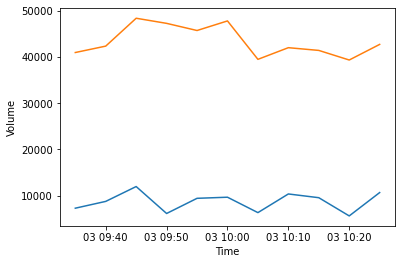

In [11]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

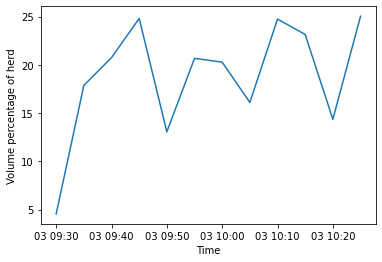

In [12]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [23]:
slave_ids = []
for path in PATHS:
    for file in os.listdir(path):  
        if 'ZIAgent' in file:
            try:
                s_id = int(file.split('ZIAgent')[1].split('Type')[0])
                slave_ids.append(s_id)
            except (IndexError, KeyError):
                continue


In [26]:
df = pd.read_pickle(os.path.join(PATHS[0],'EXCHANGE_AGENT.bz2'), compression='bz2')
df = df[df.EventType == 'ORDER_EXECUTED']
df.reset_index(inplace=True)

In [27]:
temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
temp['EventTime'] = df.EventTime
temp

,agent_id,time_placed,symbol,quantity,is_buy_order,order_id,fill_price,tag,limit_price,EventTime
0,5610,2020-06-03T09:30:00.000059408,ABM,44,True,4,99945,None,100134,2020-06-03 09:30:00.000089093
1,5040,2020-06-03T09:30:00.000049911,ABM,44,0,2,99945,None,99945,2020-06-03 09:30:00.000089093
2,5074,2020-06-03T09:30:00.000109218,ABM,33,0,12,100145,None,100078,2020-06-03 09:30:00.000163810
3,5689,2020-06-03T09:30:00.000067686,ABM,33,True,7,100145,None,100145,2020-06-03 09:30:00.000163810
4,5459,2020-06-03T09:30:00.000109921,ABM,67,False,13,100145,None,99254,2020-06-03 09:30:00.000164892
...,...,...,...,...,...,...,...,...,...,...
134529,5087,2020-06-03T10:29:59.322618168,ABM,6,False,107415,99830,None,99830,2020-06-03 10:29:59.479919962
134530,5068,2020-06-03T10:29:59.909215673,ABM,35,False,107421,99829,None,99829,2020-06-03 10:29:59.910433905
134531,5024,2020-06-03T10:29:59.078428780,ABM,35,True,107411,99829,None,99829,2020-06-03 10:29:59.910433905
134532,5068,2020-06-03T10:29:59.909215673,ABM,1,False,107421,99829,None,99829,2020-06-03 10:29:59.910433905


In [30]:
t = temp[temp.agent_id.isin(slave_ids)][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()

In [31]:
t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
t['SIMULATION'] = path
t['tot_vol'] = t1.tot_vol

In [32]:
t

,slave_vol,SIMULATION,tot_vol
EventTime,,,
2020-06-03 09:30:00,23541,log/herd02_2_5_hour_1/,135506
2020-06-03 09:35:00,2469,log/herd02_2_5_hour_1/,40944
2020-06-03 09:40:00,2585,log/herd02_2_5_hour_1/,42328
2020-06-03 09:45:00,3089,log/herd02_2_5_hour_1/,48349
2020-06-03 09:50:00,2600,log/herd02_2_5_hour_1/,47244
2020-06-03 09:55:00,2682,log/herd02_2_5_hour_1/,45700
2020-06-03 10:00:00,2178,log/herd02_2_5_hour_1/,47770
2020-06-03 10:05:00,2324,log/herd02_2_5_hour_1/,39470
2020-06-03 10:10:00,1802,log/herd02_2_5_hour_1/,41989
